In [2]:
import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
import requests, html5lib, re

In [3]:
dmaZip = pd.read_csv("data/dma_to_zipcode.csv")
dmaZip = dmaZip.iloc[:,1:]
dmaZip.rename({'dma_description':"dma"},axis=1, inplace=True)
dmaZip.head()

,zip_code,dma_code,dma
0,1001,543,SPRINGFIELD - HOLYOKE
1,1002,543,SPRINGFIELD - HOLYOKE
2,1003,543,SPRINGFIELD - HOLYOKE
3,1004,543,SPRINGFIELD - HOLYOKE
4,1005,506,BOSTON (MANCHESTER)


In [4]:
if "dma" in dmaZip.columns:
    dmaZip.set_index(["dma"], inplace=True)

dmaZip.sort_index(inplace=True)
dmaZip.head(100)

,zip_code,dma_code
dma,,
ABILENE - SWEETWATER,79601,662
ABILENE - SWEETWATER,79563,662
ABILENE - SWEETWATER,79565,662
ABILENE - SWEETWATER,79566,662
ABILENE - SWEETWATER,79567,662
...,...,...
ABILENE - SWEETWATER,76483,662
ABILENE - SWEETWATER,76491,662
ALBANY - SCHENECTADY - TROY,12201,532


In [6]:
dmaPivot = dmaZip.pivot_table(index=dmaZip.index, values = ['zip_code'], aggfunc='max')
dmaPivot.reset_index(inplace=True)
dmaPivot["dmaLocal"]= dmaPivot.dma.apply(lambda x: x.split("-")[0].split(",")[0])
dmaPivot

,dma,zip_code,dmaLocal
0,ABILENE - SWEETWATER,97,ABILENE
1,ALBANY - SCHENECTADY - TROY,364,ALBANY
2,"ALBANY, GA",75,ALBANY
3,ALBUQUERQUE - SANTA FE,404,ALBUQUERQUE
4,"ALEXANDRIA, LA",63,ALEXANDRIA
...,...,...,...
205,WILMINGTON,58,WILMINGTON
206,YAKIMA - PASCO - RCHLND - KNNWCK,73,YAKIMA
207,YOUNGSTOWN,101,YOUNGSTOWN
208,YUMA - EL CENTRO,29,YUMA


In [135]:
stations = pd.read_csv('data/auc_stations.csv')
stations.drop(["off_air_option","lvhf_option","hvhf_option", "auction_id"], axis=1,inplace=True)
stations["local"] = stations["dma"].apply(lambda x: x.split(",")[0].upper())
stations.head()


,bidder,frn,call_sign,facility_id,dma,pre_auction_band,volume,off_air_opening_price,lvhf_opening_price,hvhf_opening_price,local
0,BlueStone License Holdings Inc.,10338895,KTXS-TV,308,"Abilene-Sweetwater, TX",UHF,70068,63061200,47295900.0,25224480.0,ABILENE-SWEETWATER
1,"Sunbelt-South Tele-Communications, Ltd.",5806096,WSST-TV,63867,"Albany, GA",UHF,88603,79742700,59807025.0,31897080.0,ALBANY
2,"Gray Television Licensee, LLC",18223693,WSWG,28155,"Albany, GA",UHF,88926,80033400,60025050.0,32013360.0,ALBANY
3,"Young Broadcasting of Albany, Inc.",3453644,WCDC-TV,74419,"Albany-Schenectady-Troy, NY",UHF,234546,211091400,158318550.0,84436560.0,ALBANY-SCHENECTADY-TROY
4,"Sleezer, Michael A",3772829,WFNY-CD,167948,"Albany-Schenectady-Troy, NY",UHF,29898,26908200,20181150.0,10763280.0,ALBANY-SCHENECTADY-TROY


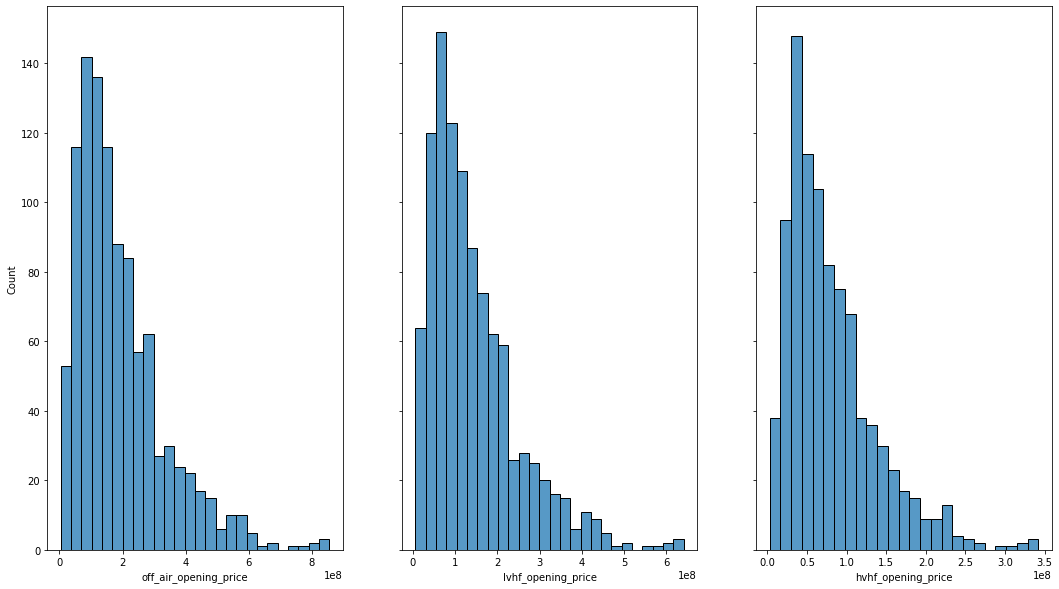

In [136]:
offAir = "off_air_opening_price"
lvhf = "lvhf_opening_price"
hvhf = "hvhf_opening_price"
band = "pre_auction_band"

fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

ax1 = sns.histplot(ax=axes[0], data=stations,x=offAir)
ax2 = sns.histplot(ax=axes[1], data=stations,x=lvhf)
ax3 = sns.histplot(ax=axes[2], data=stations,x=hvhf)


In [137]:
stationZip = stations.merge(dmaPivot, left_on="local", right_on="dmaLocal", how="inner")
stationZip.fillna(np.nan, inplace=True)
stationZip.zip_code.astype(np.float64)
stationZip.rename({'zip_code':'zipcode'}, axis=1, inplace=True)
stationZip.to_csv("data/bidZip.csv")
stationZip.head()

,bidder,frn,call_sign,facility_id,dma_x,pre_auction_band,volume,off_air_opening_price,lvhf_opening_price,hvhf_opening_price,local,dma_y,zipcode,dmaLocal
0,"Sunbelt-South Tele-Communications, Ltd.",5806096,WSST-TV,63867,"Albany, GA",UHF,88603,79742700,59807025.0,31897080.0,ALBANY,"ALBANY, GA",39885,ALBANY
1,"Gray Television Licensee, LLC",18223693,WSWG,28155,"Albany, GA",UHF,88926,80033400,60025050.0,32013360.0,ALBANY,"ALBANY, GA",39885,ALBANY
2,"Wilderness Communications, LLC",14881114,KBCA,16940,"Alexandria, LA",UHF,99564,89607600,67205700.0,35843040.0,ALEXANDRIA,"ALEXANDRIA, LA",71496,ALEXANDRIA
3,"Pollack/Belz Communication Co., Inc.",6096200,KLAX-TV,52907,"Alexandria, LA",UHF,95366,85829400,64372050.0,34331760.0,ALEXANDRIA,"ALEXANDRIA, LA",71496,ALEXANDRIA
4,Thunder Bay Broadcasting Corporation,12088241,WBKB-TV,67048,"Alpena, MI",High-VHF,38851,20979540,12238065.0,NaN,ALPENA,ALPENA,49766,ALPENA


In [138]:
census = pd.read_csv('data/census_zip.csv')
census.tail()

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
166447,56,WY,99999,2,3490.0,2010.0,940.0,440.0,3290.0,70.0,...,0.0,0.0,440.0,590.0,2930.0,8141.0,2880.0,7855.0,50.0,86.0
166448,56,WY,99999,3,2350.0,1030.0,1080.0,200.0,2220.0,50.0,...,0.0,0.0,460.0,947.0,1800.0,5772.0,1720.0,5164.0,70.0,257.0
166449,56,WY,99999,4,1700.0,530.0,1080.0,100.0,1630.0,30.0,...,0.0,0.0,410.0,1052.0,1230.0,4529.0,1160.0,4188.0,50.0,139.0
166450,56,WY,99999,5,2560.0,420.0,2080.0,80.0,2470.0,40.0,...,0.0,0.0,820.0,3897.0,1660.0,8677.0,1480.0,7299.0,200.0,1036.0
166451,56,WY,99999,6,830.0,160.0,700.0,0.0,850.0,0.0,...,510.0,3685.0,390.0,12002.0,400.0,18594.0,170.0,2893.0,230.0,13413.0


In [139]:
def toMoney(series):
    if series == 1:
        return 25000
    if series == 2:
        return 50000
    if series == 3:
        return 75000
    if series == 4:
        return 100000
    if series == 5:
        return 200000
    if series == 6:
        return 250000

census["income"] = census["agi_stub"].apply(toMoney)
census.head()
for c in census.columns:
    if "MAR" in c or "mar" in c or "1" in c or "0" in c \
        or "5" in c or "F" in c or "R" in c or "VITA" in c \
        or "N" in c or "TCE" in c:
            census.drop(c, axis = 1, inplace=True)

census.head()

,STATE,zipcode,agi_stub,income
0,AL,0,1,25000
1,AL,0,2,50000
2,AL,0,3,75000
3,AL,0,4,100000
4,AL,0,5,200000


In [140]:
census.rename({'STATE':'state'}, axis = 1,inplace=True)
census.to_csv('data/cleaned_census.csv')
census.head()

,state,zipcode,agi_stub,income
0,AL,0,1,25000
1,AL,0,2,50000
2,AL,0,3,75000
3,AL,0,4,100000
4,AL,0,5,200000


In [141]:
censusStationZip = stationZip.merge(census, how = 'left', on='zipcode')
censusStationZip.dropna(axis=0, inplace=True)
censusStationZip.to_csv("data/bid_zip_income.csv")
censusStationZip.head()

,bidder,frn,call_sign,facility_id,dma_x,pre_auction_band,volume,off_air_opening_price,lvhf_opening_price,hvhf_opening_price,local,dma_y,zipcode,dmaLocal,state,agi_stub,income
10,Central Michigan University,2733764,WCML,9917,"Alpena, MI",UHF,67730,60957000,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,1.0,25000.0
11,Central Michigan University,2733764,WCML,9917,"Alpena, MI",UHF,67730,60957000,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,2.0,50000.0
12,Central Michigan University,2733764,WCML,9917,"Alpena, MI",UHF,67730,60957000,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,3.0,75000.0
13,Central Michigan University,2733764,WCML,9917,"Alpena, MI",UHF,67730,60957000,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,4.0,100000.0
14,Central Michigan University,2733764,WCML,9917,"Alpena, MI",UHF,67730,60957000,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,5.0,200000.0


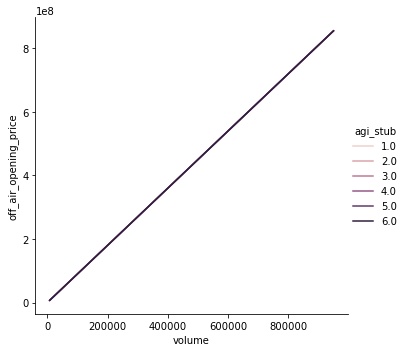

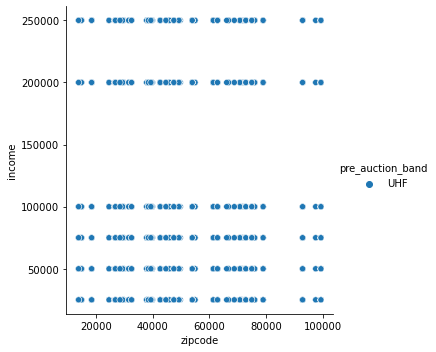

In [142]:
offAir = "off_air_opening_price"
lvhf = "lvhf_opening_price"
hvhf = "hvhf_opening_price"
band = "pre_auction_band"

palette = sns.color_palette("rocket_r")

sns.relplot(data = censusStationZip, x = 'volume', y = offAir, hue='agi_stub', kind="line")
sns.relplot(data = censusStationZip, x = 'zipcode', y = "income", hue=band, markers=False)

#g = sns.FacetGrid(censusStationZip, col="pre_auction_band")
#g.map(sns.scatterplot, offAir, "income")

In [143]:
popZip = pd.read_csv("data/pop_zip.csv")
popZip = pd.concat([popZip['zipcode'], popZip['population']],axis=1)
popZip.population=popZip['population']*1000
popZip.head()

,zipcode,population
0,61747,50000
1,64120,5000
2,95117,1389000
3,74074,231000
4,58042,56000


In [148]:
bidZipPopIncome = censusStationZip.merge(popZip, on="zipcode", how = 'outer')
#bidZipPopIncome[offAir] = bidZipPopIncome[offAir] / bidZipPopIncome['population']
bidZipPopIncome.eval("pop_per_income = population / income",inplace=True)
#bidZipPopIncome.to_csv("data/bidZipPopIncome.csv")
bidZipPopIncome.dropna(axis = 0, inplace=True)
bidZipPopIncome.head()

,bidder,frn,call_sign,facility_id,dma_x,pre_auction_band,volume,off_air_opening_price,lvhf_opening_price,hvhf_opening_price,local,dma_y,zipcode,dmaLocal,state,agi_stub,income,population,pop_per_income
0,Central Michigan University,2733764.0,WCML,9917.0,"Alpena, MI",UHF,67730.0,60957000.0,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,1.0,25000.0,28000,1.12
1,Central Michigan University,2733764.0,WCML,9917.0,"Alpena, MI",UHF,67730.0,60957000.0,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,1.0,25000.0,59000,2.36
2,Central Michigan University,2733764.0,WCML,9917.0,"Alpena, MI",UHF,67730.0,60957000.0,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,1.0,25000.0,52000,2.08
3,Central Michigan University,2733764.0,WCML,9917.0,"Alpena, MI",UHF,67730.0,60957000.0,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,1.0,25000.0,61000,2.44
4,Central Michigan University,2733764.0,WCML,9917.0,"Alpena, MI",UHF,67730.0,60957000.0,45717750.0,24382800.0,ALPENA,ALPENA,49766,ALPENA,MI,1.0,25000.0,124000,4.96


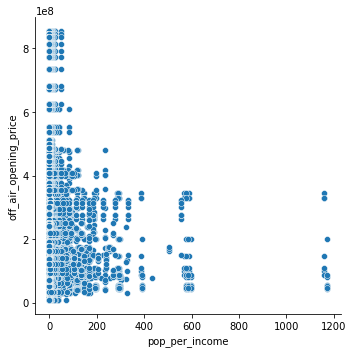

In [145]:
sns.relplot(data = bidZipPopIncome, x = 'pop_per_income', y = offAir)

In [146]:
pt = bidZipPopIncome.pivot_table(index='dma_x', values = 'frn', aggfunc='count')
pt.shape[0]
pt.head()

,frn
dma_x,
"Alpena, MI",294
"Austin, TX",2940
"Binghamton, NY",882
"Bowling Green, KY",588
"Charleston, SC",294
